# Good Vibes: The Probability of Earthquake Magnitude and Death
*The Final Report for the Introduction to Data Science Project*  
  
**Team Fugacity Members**  
Paul Mundt, u0932146  
Katie Jones, u0541901  
  
  
  
*Note: To run this jupyter notebook, the pycountry database and folium library must be installed.*

***Accompanying Video Link:***



## Introduction [Check Off: Katie, Paul]

### Motivations
  
Last year on February 15th, 2019 at 05:09am (MST) a 3.7M earthquake hit Bluffdale, UT. The magnitude was enough for residents in neighboring cities such as Draper and Riverton, to feel the ground shake. This caused many nearby citizens to wonder about their safety and question their preparedness for the next earthquake. As residents of a city built on a faultline, we are keenly aware of the ubiquity of earthquakes as a disruption to life in Salt Lake City.  
  
Earthquakes happen all over the world, most of which we cannot feel. As citizens living along a major faultline, the question of earthquake magnitude and danger has always been a concern. This project will look at the historical data of earthquakes around the globe and determine the danger of displacement, property damage, injury, death, etc. (called impact factors from this point forward) in relation to earthquake magnitude and other socioeconomic factors.
  
  
### Project Objectives
  
For this project, we are trying to answer the following questions about earthquakes and their impacts:

**1**) Can impact factors be predicted based on magnitude of the earthquake?
  
**2**) What is the probability of an earthquake of any magnitude?
  
**3**) How do socioeconomic factors (like GDP of the country, population, etc) affect the accuracy of impact factor predictions?
  
**4**) Does clustering of data prior to analysis increase the accuracy of the predictive models? 
  
We will be investigating these claims by analyzing seismographic information about earthquakes, information about effects of earthquakes, and looking at a variety of other data types (national GDP, population, population density, etc) . 
 
Additionally, we hope to apply the data collected to a geomap for a visualization of earthquake locations and severity. 
  
### Ethical Considerations [Edits Needed]
  
The main stakeholders in a data science project like this are general civilians and people involved in infrastructure (architects, city planners, civil engineers, law makers, etc). 
To the general citizen, this project can be both incredibly informative as well as fear inducing. Most people only gain exposure to earthquakes after a major disaster. Because of this, many people inherently fear earthquakes and the impact that they have on daily life. For this project, it is important that all correlations and statistics we explore are accurately and accessible explained and given context. As is often the case, the context given to the data is usually more important than what the data itself says. 
  
This project could be useful for people involved in infrastructure. By showing what variables that affect impact factors, the people incharge of building structures in a city might be better informed on the need for earthquake resistant structures. Areas of frequent high magnitude earthquakes are supposedly safer than those with the semi-active seismic activity. We believe this is because infrastructure and response are more highly valued when building in the area, as more frequent danger incentivises buildings to be designed to withstand move intense oscillation.

## Data Collection and Cleaning [Check Off: Katie, Paul]

### Earthquakes and Impact Factor Data
The primary source of data was the Earthquake Impact Database from earthquake-report.com. The database from the website is linked to a set of Goolge sheets that can be saved as a CSV. The CSV files had to be copied and saved to replace formulas with text. This was done using Excel's specialty paste functionality.  
The data was collected from January 1, 2017 to March 17th, 2020.  
  
We will be keeping information about the following impact factors:  
- Intensity
- Fatalities
- Injuries
- Displaced
- Impact Value
- Buildings Damaged
- Buildings Destroyed
  
Intensity is defined by the United States Geological Society (USGS) to be "a number (written as a Roman numeral) describing the severity of an earthquake in terms of its effects on the earth's surface and on humans and their structures" [A].
  
Impact Value is a factor determined by the curators of the Earthquake Impact Database. They describe is as,  
*"The "Impact Value" is used to compare the effects of different earthquakes. Numbers of casualties, damage and displaced people contribute to the calculation in a different degree. The value is given on a logarithmic scale."*[B]  
The Impact Value is calculated using the following formula: $$Impact Value = \ln\left[\left(\sum^n_j C_{I,j}I_{j}\right)+1\right]$$
Where $I$ denoted the total number of occurances of an impact factor (number of fatalities), the subscript $j$ indicates the impact factor in question, and $C_I$ is a scaling factor for impact factors. It scales everything against the number of fatalities. 

In [1]:
# Import all packages and functions needed for entire analysis
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import scipy as sci
from requests import get
import folium
from geopy.geocoders import ArcGIS
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
import pycountry
import re
from scipy.cluster import hierarchy 
from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA 
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (12, 12) 
import statsmodels.formula.api as sm

In [2]:
# Import CSV Files Extracted from the Earthquake Impact Database
data_2017 = pd.read_csv("2017_raw.csv", encoding = "ISO-8859-1").dropna(axis = 0, how = "all")
data_2018 = pd.read_csv("2018_raw.csv", encoding = "ISO-8859-1").dropna(axis = 0, how = "all")
data_2019 = pd.read_csv("2019_raw.csv", encoding = "ISO-8859-1").dropna(axis = 0, how = "all")
data_2020 = pd.read_csv("2020_raw.csv", encoding = "ISO-8859-1").dropna(axis = 0, how = "all", thresh = 2)

In [3]:
# Clean 2017 Data
data_2017 = data_2017.drop('Depth (km)', axis = 1).drop('Tsunami height', axis = 1)
data_2017 = data_2017.fillna(value = 0).replace("--", "0")
latlong_2017 = [0 for _ in range(0, len(data_2017.index))]
data_2017.insert(loc = 4, column = 'Lat', value = latlong_2017)
data_2017.insert(loc = 5, column = 'Long', value = latlong_2017)
data_2017 = data_2017.rename(columns = {"Impact coefficient (D)" : "Impact value (D)"} )

# Clean 2018 Data
data_2018 = data_2018.drop('Depth (km)', axis = 1).drop('Type', axis = 1).drop('Origin', axis = 1).drop('Tsunami height', axis = 1)
data_2018 = data_2018.fillna(value = 0).replace("--", "0")
latlong_2018 = [0 for _ in range(0, len(data_2018.index))]
data_2018.insert(loc = 4, column = 'Lat', value = latlong_2018)
data_2018.insert(loc = 5, column = 'Long', value = latlong_2018)
data_2018 = data_2018.rename(columns = {"Country (Epicenter)" : "Country", "Region (Epicenter)" : "Region"} )

# Clean 2019 Data
data_2019 = data_2019.drop('Depth (km)', axis = 1).drop('Type', axis = 1).drop('Origin', axis = 1).drop('Tsunami height', axis = 1)
data_2019 = data_2019.fillna(value = 0).replace("--", "0")
data_2019 = data_2019.rename(columns = {"Country (Epicenter)" : "Country", "Region (Epicenter)" : "Region"} )

# Clean 2020 Data
data_2020 = data_2020.drop('Depth (km)', axis = 1).drop('Type', axis = 1).drop('Origin', axis = 1).drop('Tsunami height', axis = 1)
data_2020 = data_2020.fillna(value = 0)
data_2020 = data_2020.rename(columns = {"Epicenter" : "Country", "Region (Epicenter)" : "Region"} )

In [4]:
# Concatenate Dataframes into a Single Dataset
earthquake_data = pd.concat([data_2017, data_2018, data_2019, data_2020], sort = False).reset_index(drop = True)
Database = pd.concat([data_2019, data_2020], sort = False).reset_index(drop = True)

In [5]:
# Convert "Intensity (MMI / JMA)" Column from Roman Numerals to Integers
earthquake_data['Intensity (MMI / JMA)']=earthquake_data['Intensity (MMI / JMA)'].str.replace('+',' ')
earthquake_data['Intensity (MMI / JMA)']=earthquake_data['Intensity (MMI / JMA)'].str.replace('-',' ')
earthquake_data['Intensity (MMI / JMA)']=earthquake_data['Intensity (MMI / JMA)'].str.replace('JMA',' ')
earthquake_data['Intensity (MMI / JMA)']=earthquake_data['Intensity (MMI / JMA)'].str.replace('/ 7',' ')
earthquake_data['Intensity (MMI / JMA)']=earthquake_data['Intensity (MMI / JMA)'].str.replace('Shindo ','')

Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('+',' ')
Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('-',' ')
Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('JMA',' ')
Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('/ 7',' ')
Database['Intensity (MMI / JMA)']=Database['Intensity (MMI / JMA)'].str.replace('Shindo ','')

def roman_to_number(num):
    rom_val = {'I': 1, 'V': 5, 'X': 10, 'L':50 , 'C':100, 'D':500, 'M':1000}
    res=0
    i=0
    while i<len(num):
        s1=num[i]
        num1=rom_val[s1]
        if i+1<len(num):
            s2=num[i+1]
            num2=rom_val[s2]
            if num2<=num1:
                res=res+num1
                i+=1
            else:
                res=res+num2-num1
                i+=2
        else:
            res=res+num1
            i+=1
    return(res)
        
    
           
def change(num):
    if type(num)==str:
        if len(num)>4:
            tip=num[0:len(num)//2].strip()
        else:
            tip=num.strip()
        try:
            return(int(tip))
        except:
            return(roman_to_number(tip))
    else:
        return(num)
earthquake_data['Intensity (MMI / JMA)']=[change(chest) for chest in earthquake_data['Intensity (MMI / JMA)']]
Database['Intensity (MMI / JMA)']=[change(chest) for chest in Database['Intensity (MMI / JMA)']]

In [6]:
# Print Cleaned DataFrame
earthquake_data

,Date (UTC),Country,Region,Magnitude,Lat,Long,Intensity (MMI / JMA),Fatalities,Injuries,displaced,Impact value (D),buildings damaged,buildings destroyed
0,1/2/2017,Italy,Umbria,4.1,0.00,0.00,5.0,0.0,0.0,30.0,0.194401,0.0,0.0
1,1/3/2017,India,Tripura,5.5,0.00,0.00,NaN,3.0,49.0,600.0,1.668774,1456.0,166.0
2,1/3/2017,Brazil,Maranhao,4.6,0.00,0.00,NaN,0.0,0.0,0.0,0.752967,500.0,0.0
3,1/3/2017,Fiji,Western Division (OS),7.2,0.00,0.00,4.0,0.0,0.0,0.0,0.000000,0.0,0.0
4,1/6/2017,Iran,Fars,5.1,0.00,0.00,NaN,4.0,4.0,905.0,1.447852,400.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,3/13/2020,India,Kerala,2.8,9.79,76.88,NaN,0.0,0.0,0.0,0.038254,10.0,0.0
934,3/13/2020,Tanzania,Tanga,4.8,-4.90,38.55,NaN,0.0,0.0,0.0,0.007925,2.0,0.0
935,3/14/2020,Iran,Qom,4.0,34.56,50.72,NaN,0.0,0.0,0.0,0.038254,10.0,0.0
936,3/15/2020,Iran,Hormozgan,5.4,27.20,55.32,NaN,0.0,2.0,0.0,0.235972,20.0,1.0


### Socioeconomic Information
Socioeconomic information for every country was scraped from World-o-meters.info. All aspects of GDP growth were scrapped including Population, GDP% growth ad GDP Per capita to name a few.

In [7]:
#Scrape Socioeconomic Information
url = 'https://www.worldometers.info/gdp/gdp-by-country/'
response=get(url)
soup=BeautifulSoup(response.text,'html.parser')
Head=soup.find('thead')
H=Head.find_all('th')
Table=soup.find('tbody')
T=Table.find_all('tr')
columns=[col for col in T[0]]
Beep=[T[i] for i in range(0,len(T))]
headers=[i.get_text() for i in H]

tipping=[]
for col in columns:
    if col==' ':
        pass
    else:
        tipping.append(col.get_text())
tip=[]
for i in range(0,len(T)):
    clip=[]
    columns=[col for col in T[i]]
    for col in columns:
        if col==' ':
            pass
        else:
            clip.append(col.get_text())
    tip.append(clip)
gdp=pd.DataFrame(tip,columns=headers)

#cleaning GDP nominal
gdp['GDP (nominal, 2017) ']=gdp['GDP (nominal, 2017) '].str.replace('$',' ')
gdp['GDP (nominal, 2017) ']=gdp['GDP (nominal, 2017) '].str.replace(',','').astype(float)
gdp['GDP (nominal, 2017) ']=pd.to_numeric(gdp['GDP (nominal, 2017) '] )
gdp.rename(columns={'GDP (nominal, 2017) ':'GDP($)'}, inplace=True)

#Cleanng GDP abbrev
gdp['GDP (abbrev.)']=gdp['GDP (abbrev.)'].str.replace('$',' ')
def money(num,part):
    if part=='trillion':
        num=num*1000000000000
    elif part=='billion':
        num=num*1000000000
    else:
        num=num*1000000
    return(num)

def marker(plop):
    mak=len(plop)//2
    num=plop[0:mak]
    word=plop[mak:len(plop)]
    if word=='illion' or word=='rillion' :
        num=float(plop[0:mak-1])
        word=plop[mak-1:len(plop)]
        return(money(num,word))
    else:
        return(money(float(num),word))
gdp['GDP (abbrev.)']=[marker(i) for i in gdp['GDP (abbrev.)']]
gdp.rename(columns={'GDP (abbrev.)':'GDP (abbrev.)($)'}, inplace=True)

#clean growth
gdp['GDP  growth']=gdp['GDP  growth'].str.replace('%','').astype(float).divide(100)
gdp.rename(columns={'GDP  growth':'GDP  growth(%)'}, inplace=True)
#clean population
gdp['Population (2017) ']=gdp['Population (2017) '].str.replace(',','').astype(int)
gdp.rename(columns={'Population (2017) ':'Population'}, inplace=True)
#clean per capita
gdp['GDP  per capita ']=gdp['GDP  per capita '].str.replace('$',' ').str.replace(',','').astype(int)
gdp.rename(columns={'GDP  per capita ':'GDP  per capita ($)'}, inplace=True)
#share of GDP
gdp['Share of World GDP ']=gdp['Share of World GDP '].str.replace('%','').astype(float).divide(100)
gdp.rename(columns={'Share of World GDP ':'Share of World GDP (%)'}, inplace=True)

In [8]:
# print DataFrame
gdp

,#,Country,GDP($),GDP (abbrev.)($),GDP growth(%),Population,GDP per capita ($),Share of World GDP (%)
0,1,United States,1.948539e+13,1.948500e+13,0.0227,325084756,59939,0.2408
1,2,China,1.223770e+13,1.223800e+13,0.0690,1421021791,8612,0.1512
2,3,Japan,4.872415e+12,4.872000e+12,0.0171,127502725,38214,0.0602
3,4,Germany,3.693204e+12,3.693000e+12,0.0222,82658409,44680,0.0456
4,5,India,2.650725e+12,2.651000e+12,0.0668,1338676785,1980,0.0328
...,...,...,...,...,...,...,...,...
184,185,Sao Tome & Principe,3.925703e+08,3.930000e+08,0.0387,207089,1896,0.0000
185,186,Palau,2.898235e+08,2.900000e+08,-0.0357,17808,16275,0.0000
186,187,Marshall Islands,2.041734e+08,2.040000e+08,0.0360,58058,3517,0.0000
187,188,Kiribati,1.855725e+08,1.860000e+08,0.0033,114158,1626,0.0000


### Adding Socioeconomic Data to Earthquake Data
Next we used the "GDP" DataFrame as a database of sorts. The earthquake data has the country of epicenter listed, so that was compared to the list from World-o-meter.info and the GDP, GDP per capita, and Population were added to the earthquake data.  
In the World-o-meter.info data, information about 4 countries were missing: Taiwan, Venezuela, Myamnar, and Cayman Islands. The pertinent information about these countries was collected from their Wikipedia pages and added manually to earthquakes located in those countires.[C,D,E,F]

In [9]:
#Add GDP, Population and GDP per captia to lists for addition to DF

gdp_column = []
pop_column = []
gdp_per_cap_column = []

for i in range(len(earthquake_data)):
    country = earthquake_data.iloc[i, 1]
    if country == "Taiwan":
        gdp_column.append(586104000000)
        pop_column.append(23780452)
        gdp_per_cap_column.append(24828)
    if country == "Venezuela":
        gdp_column.append(70140000000)
        pop_column.append(28887118)
        gdp_per_cap_column.append(2548)
    if country == "Myamnar":
        gdp_column.append(355000000000)
        pop_column.append(53582855)
        gdp_per_cap_column.append(6707)
    if country == "Cayman Islands":
        gdp_column.append(4571000000)
        pop_column.append(68076)
        gdp_per_cap_column.append(70958)
    for j in range(len(gdp)):
        if gdp.iloc[j, 1] == country:
            gdp_column.append(gdp.iloc[j, 2])
            pop_column.append(gdp.iloc[j, 5])
            gdp_per_cap_column.append(gdp.iloc[j, 6])
            break

# Insert columns onto dataframe
earthquake_data.insert(loc = 13, column = 'GDP', value = gdp_column)
earthquake_data.insert(loc = 14, column = 'Population', value = pop_column)
earthquake_data.insert(loc = 15, column = 'GDPPerCapita', value = gdp_per_cap_column)

### Finding Countries Relating to Continents and Land Area
In order to get a better understanding of a population density as well as land area for a country, land area in square miles was scraped and added to the earthquake_data dataframe. 

In [10]:
url1 = 'https://www.worldatlas.com/cntycont.htm'
url2='https://www.nationmaster.com/country-info/stats/Geography/Land-area/Square-miles'

response=get(url1)
soup=BeautifulSoup(response.text,'html.parser')

Tropicanna=soup.find('div',class_="miscTxt")
continents=Tropicanna.find_all('h2')
cont_counts=Tropicanna.find_all('ul')
top=cont_counts[1].find_all('li')
Conts=[con.get_text() for con in continents]
Countries=[]
Continets=[]
for j in range(len(Conts)-2):
    stuff=Conts[j]
    top=cont_counts[j].find_all('li')
    for steel in top:
        Countries.append(steel.get_text())
        Continets.append(stuff)

ConCun=pd.DataFrame(zip(Countries,Continets), columns=['Country','Continents'])
ConCun['Continents']=ConCun['Continents'].str.replace('(','').str.replace(')','').str.replace('\n','')
ConCun['Continents']=[title[0:len(title)-3] for title in ConCun['Continents']]

response1=get(url2)
sauce=BeautifulSoup(response1.text,'html.parser')

tim=sauce.find('tbody')
info=tim.find_all('tr')
country=[]
land=[]
for i in range(0,len(info)):
    test=info[i].find_all('td')
    country.append(test[1].get_text())
    land.append(test[2].get_text().strip())
    
landmass=pd.DataFrame(zip(country,land), columns=['Country','Landarea'])
landmass['Country']=landmass['Country'].str.replace('\n','')
landmass['Landarea']=landmass['Landarea'].str.replace('square miles','').str.replace(',','')
time=[]
for tim in landmass['Landarea']:
    if 'million' in tim:
        time.append(float(tim[0:4])*1000000)
    else:
        time.append(float(tim))
landmass['Landarea']=time
Information=ConCun.join(landmass.set_index('Country'), on='Country')
earthquake_data=earthquake_data.join(Information.set_index('Country'), on='Country')

In [11]:
# print final DataFrame
earthquake_data

,Date (UTC),Country,Region,Magnitude,Lat,Long,Intensity (MMI / JMA),Fatalities,Injuries,displaced,Impact value (D),buildings damaged,buildings destroyed,GDP,Population,GDPPerCapita,Continents,Landarea
0,1/2/2017,Italy,Umbria,4.1,0.00,0.00,5.0,0.0,0.0,30.0,0.194401,0.0,0.0,1.943835e+12,60673701,32038,EUROPE,116346.0
1,1/3/2017,India,Tripura,5.5,0.00,0.00,NaN,3.0,49.0,600.0,1.668774,1456.0,166.0,2.650725e+12,1338676785,1980,ASIA,1240000.0
2,1/3/2017,Brazil,Maranhao,4.6,0.00,0.00,NaN,0.0,0.0,0.0,0.752967,500.0,0.0,2.053595e+12,207833823,9881,S. AMERICA,3300000.0
3,1/3/2017,Fiji,Western Division (OS),7.2,0.00,0.00,4.0,0.0,0.0,0.0,0.000000,0.0,0.0,5.061203e+09,877459,5768,OCEANIA,7095.0
4,1/6/2017,Iran,Fars,5.1,0.00,0.00,NaN,4.0,4.0,905.0,1.447852,400.0,40.0,4.540128e+11,80673883,5628,ASIA,636313.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,3/13/2020,India,Kerala,2.8,9.79,76.88,NaN,0.0,0.0,0.0,0.038254,10.0,0.0,2.650725e+12,1338676785,1980,ASIA,1240000.0
934,3/13/2020,Tanzania,Tanga,4.8,-4.90,38.55,NaN,0.0,0.0,0.0,0.007925,2.0,0.0,5.332063e+10,54660339,975,AFRICA,364900.0
935,3/14/2020,Iran,Qom,4.0,34.56,50.72,NaN,0.0,0.0,0.0,0.038254,10.0,0.0,4.540128e+11,80673883,5628,ASIA,636313.0
936,3/15/2020,Iran,Hormozgan,5.4,27.20,55.32,NaN,0.0,2.0,0.0,0.235972,20.0,1.0,4.540128e+11,80673883,5628,ASIA,636313.0


## Data Exploration [Check Off: Katie, Paul]
  
The first method of data exploration was to look at a geo map of earthquake data collected from the USGS website. This geomap was used to see if we could visually see any patterns that might inform the clustering a regression analysis we did later on. 

In [12]:
# Because of the frequency of earthquakes, USGS data takes all earthquake data all over the world and gives us the magnitude, longitude
#latitude, and depth. From there we can plot these on a Geomap or scatter plot and see if any patterns come up
url = 'http://feed.unmung.com/feed?feed=http://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/4.5+_month.atom'
response=get(url)
soup=BeautifulSoup(response.text,'html.parser')

Location=soup.find_all('a',class_="u-url")
Data=soup.find_all('span',class_="e-summary")
Location.pop(0)
def mag_title(x):
    magnitude=float(x[1:5])
    location=x[7:]
    return(magnitude,location)

Locate=[]
magni=[]
for kip in Location:
    inter=kip.get_text()
    poper=mag_title(inter)
    Locate.append(poper[1])
    magni.append(poper[0])

In [13]:
#Continueing to clean the data

time=[]
loc=[]
depth=[]
for stuff in Data:
    j=stuff.find_all('dd')
    time.append(j[0].get_text())
    loc.append(j[2].get_text())
    depth.append(j[3].get_text())   

def latitudel(x):
    if "S" in x:
        cord=-float(x.replace('°S',''))
    else:
        cord=float(x.replace('°N',''))
    return(cord)

def longitudel(x):
    if "W" in x:
        cord=-float(x.replace('°W',''))
    else:
        cord=float(x.replace('°E',''))
    return(cord)
def coord_split(x):
    half=len(x)//2
    first=x[:half]
    last=x[half:]
    return(first,last)

latitude=[]
longitude=[]
for sets in loc:
    x,y=coord_split(sets)
    latitude.append(latitudel(x))
    longitude.append(longitudel(y))

Current=pd.DataFrame(zip(time,Locate,magni,depth,latitude,longitude), columns=['time','Location','Magnitude','Depth (km)','latitude','longitude'])

def co(text):
    for country in pycountry.countries:
        if country.name in text:
            return(country.name)
t=[]
for i,text in enumerate(Current['Location']):
    j=re.findall(r",([\w\s]+)",text)
    if len(j)==0:
        if type(co(text)) is None:
            t.append(co(text))
        else:
            t.append(text)
    elif len(j)>0:
        t.extend(j)
    else:
        t.append(text)
Current['Country']=t
Current

,time,Location,Magnitude,Depth (km),latitude,longitude,Country
0,2020-04-15 18:43:39 UTC,"160km SE of Petropavlovsk-Kamchatskiy, Russia",5.0,10.00 km (6.21 mi),52.132,160.480,Russia
1,2020-04-15 13:30:34 UTC,"64km WNW of Sardinal, Costa Rica",5.1,24.29 km (15.09 mi),10.714,-86.198,Costa Rica
2,2020-04-15 10:59:27 UTC,"12km NE of Pinillos, Colombia",5.7,43.59 km (27.09 mi),8.999,-74.389,Colombia
3,2020-04-15 10:11:36 UTC,Southeast central Pacific Ocean,4.6,10.00 km (6.21 mi),-40.982,-84.350,Southeast central Pacific Ocean
4,2020-04-15 09:44:43 UTC,"96km SSW of Paredon, Mexico",5.1,35.00 km (21.75 mi),15.211,-94.172,Mexico
...,...,...,...,...,...,...,...
372,2020-03-17 13:21:46 UTC,Southern East Pacific Rise,4.5,10.00 km (6.21 mi),-23.383,-116.272,Southern East Pacific Rise
373,2020-03-17 11:14:10 UTC,"162km SSE of L'Esperance Rock, New Zealand",4.5,10.00 km (6.21 mi),-32.741,-178.113,New Zealand
374,2020-03-17 08:12:03 UTC,"54km NNW of Tome, Chile",5.6,33.03 km (20.52 mi),-36.156,-73.169,Chile
375,2020-03-17 05:06:29 UTC,"8km SSE of Tingloy, Philippines",4.5,124.15 km (77.14 mi),13.596,120.915,Philippines


In [14]:
# Create and display geomap of USGS Data
def cool(m):
    if 0<=m<1:
        return('green')
    elif 1<=m<2:
        return('orange')
    elif 2<=m<3:
        return('blue')
    elif 3<=m<4:
        return('teal')
    elif 5<=m<6:
        return('purple')
    elif 6<=m<7:
        return('amber')
    else:
        return('red')
    
nom=ArcGIS()
p=nom.geocode("Palais du Gouvernement,P.O. Box 4546,N'Djaména")
map=folium.Map(location=[p.latitude,p.longitude], zoom_start=2, tiles="Stamen Terrain")

html="""<h4><b>Earquakes Info</b></h4>
<p><b>Location: </b>%s</p>
<p><b>Magnitude: </b>%s</p>"""
fgv=folium.FeatureGroup(name="shake")
for la, lo, m,l in zip(latitude,longitude,magni,Locate):
    iframe=folium.IFrame(html=html %(l,str(m)),width=200,height=100)
    fgv.add_child(folium.CircleMarker(location=[la,lo],fill_color=cool(m),popup=folium.Popup(iframe),fill=True,color='black',fill_capacity=0.9))
map.add_child(fgv)

### Scatter Matrix
Next method of data exploration is to create a scattering matrix. This allowed us to visually see coorelations between different impact factors and magnitude. 

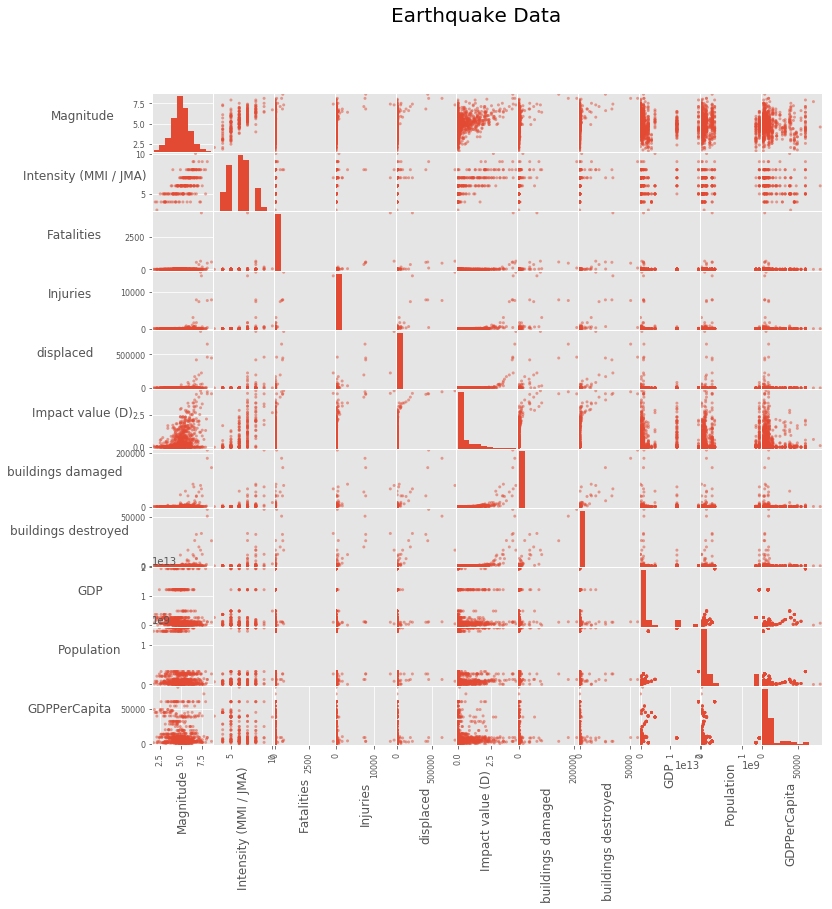

In [15]:
col=['Magnitude','Intensity (MMI / JMA)','Fatalities','Injuries','displaced','Impact value (D)','buildings damaged','buildings destroyed','GDP', 'Population','GDPPerCapita']
scattering=earthquake_data[col]
axs=pd.plotting.scatter_matrix(scattering)
plt.suptitle('Earthquake Data', size=20)
n = len(scattering.columns)
for x in range(n):
    for y in range(n):
        # to get the axis of subplots
        ax = axs[x, y]
        # to make x axis name vertical  
        ax.xaxis.label.set_rotation(90)
        # to make y axis name horizontal 
        ax.yaxis.label.set_rotation(0)
        # to make sure y axis names are outside the plot area
        ax.yaxis.labelpad = 50

## Data Analysis [Check Off: Katie, Paul]
  
### Stage 1: Complete Data Regression
Before beginning to cluster the data and group, we are running regressions on the entire data set as a whole. This is done to build a baseline of what can be predicted.  
  
First, we will complete a linear regression to find models for all impact factors as a function of magnitude.

In [16]:
# Rename columns so that there are no spaces in column names, as sm.ols won't accept them if there are spaces.
earthquake_data = earthquake_data.rename(columns = {"Intensity (MMI / JMA)" : "Intensity"} )
earthquake_data = earthquake_data.rename(columns = {"Impact value (D)" : "Impact"} )
earthquake_data = earthquake_data.rename(columns = {"buildings damaged" : "Damaged"} )
earthquake_data = earthquake_data.rename(columns = {"buildings destroyed" : "Destroyed"} )

impact_factors = ['Intensity', 'Fatalities', 'Injuries', 'Displaced', 'Impact Values', 'Damaged Buildings', 'Destroyed Buildings']

In [17]:
# Create a function that runs the regression and spits out a list of the R^2 values
def regress(dep, dat):
    #dep: a string variable that has the second half of the formula for the regression (after the ~)
    #dat: data to regression from
    
    r_squared = []
    
    intensity = sm.ols(formula = 'Intensity ~ ' + dep, data = dat).fit()
    r_squared.append(intensity.rsquared)
    
    fatalities = sm.ols(formula = 'Fatalities ~ ' + dep, data = dat).fit()
    r_squared.append(fatalities.rsquared)
    
    injuries = sm.ols(formula = 'Injuries ~ ' + dep, data = dat).fit()
    r_squared.append(injuries.rsquared)
    
    displaced = sm.ols(formula = 'displaced ~ ' + dep, data = dat).fit()
    r_squared.append(displaced.rsquared)
    
    impact = sm.ols(formula = 'Impact ~ ' + dep, data = dat).fit()
    r_squared.append(impact.rsquared)
    
    damaged = sm.ols(formula = 'Damaged ~ ' + dep, data = dat).fit()
    r_squared.append(damaged.rsquared)
    
    destroyed = sm.ols(formula = 'Destroyed ~ ' + dep, data = dat).fit()
    r_squared.append(destroyed.rsquared)
    
    return r_squared

#Function that prints the results from the previous function
def results(dep, r_squared):
    print("R-Squared Value for Regressions Done on " + dep + ":")
    for i in range(len(r_squared)):
        print("The R-Squared Value for " + impact_factors[i] + " is " + str(round(r_squared[i], 3)) + ".")
    print("")

In [18]:
#Regression on magnitude
r_squared1 = regress ('Magnitude', earthquake_data)
results ('Magnitude', r_squared1)

R-Squared Value for Regressions Done on Magnitude:
The R-Squared Value for Intensity is 0.421.
The R-Squared Value for Fatalities is 0.017.
The R-Squared Value for Injuries is 0.045.
The R-Squared Value for Displaced is 0.055.
The R-Squared Value for Impact Values is 0.188.
The R-Squared Value for Damaged Buildings is 0.068.
The R-Squared Value for Destroyed Buildings is 0.067.



As you can see, magnitude alone is not a good method to predict any of the impact factors we are interested in. This is a result we realized was likely. We believe there will be some level of dependence on a socioeconomic factor. This could be because things like GDP or GDP per capita could be indicitive of the health of the infrastructure where the earthquake occured. And the infrastructure in the location of the earthquake should have a major affect on the impact of the earthquake.

In [19]:
#Regression on Magnitude and GDP, Population, and GDP Per Capita separately
r_squared2 = regress ('Magnitude + GDP', earthquake_data)
results ('Magnitude and GDP', r_squared1)
r_squared3 = regress ('Magnitude + Population', earthquake_data)
results ('Magnitude and Population', r_squared1)
r_squared4 = regress ('Magnitude + GDPPerCapita', earthquake_data)
results ('Magnitude and GDP Per Capita', r_squared1)

R-Squared Value for Regressions Done on Magnitude and GDP:
The R-Squared Value for Intensity is 0.421.
The R-Squared Value for Fatalities is 0.017.
The R-Squared Value for Injuries is 0.045.
The R-Squared Value for Displaced is 0.055.
The R-Squared Value for Impact Values is 0.188.
The R-Squared Value for Damaged Buildings is 0.068.
The R-Squared Value for Destroyed Buildings is 0.067.

R-Squared Value for Regressions Done on Magnitude and Population:
The R-Squared Value for Intensity is 0.421.
The R-Squared Value for Fatalities is 0.017.
The R-Squared Value for Injuries is 0.045.
The R-Squared Value for Displaced is 0.055.
The R-Squared Value for Impact Values is 0.188.
The R-Squared Value for Damaged Buildings is 0.068.
The R-Squared Value for Destroyed Buildings is 0.067.

R-Squared Value for Regressions Done on Magnitude and GDP Per Capita:
The R-Squared Value for Intensity is 0.421.
The R-Squared Value for Fatalities is 0.017.
The R-Squared Value for Injuries is 0.045.
The R-Squar

None of the regressions done with a single socioeconomic factor in addition to just magnitude were much on an improvement. Now we will try some regressions using all the elements.

In [20]:
#Regression on Magnitude, GDP, Population, and GDP Per Capita
r_squared5 = regress ('Magnitude + GDP + Population + GDPPerCapita', earthquake_data)
results ('Magnitude, GDP, Population, and GDP Per Capita', r_squared1)

R-Squared Value for Regressions Done on Magnitude, GDP, Population, and GDP Per Capita:
The R-Squared Value for Intensity is 0.421.
The R-Squared Value for Fatalities is 0.017.
The R-Squared Value for Injuries is 0.045.
The R-Squared Value for Displaced is 0.055.
The R-Squared Value for Impact Values is 0.188.
The R-Squared Value for Damaged Buildings is 0.068.
The R-Squared Value for Destroyed Buildings is 0.067.



In [21]:
# Create DataFrame to display regresssion data
regression_df1 = pd.DataFrame(data = {"Magnitude": r_squared1, "Magnitude and GDP Per Capita": r_squared2, "Magnitude and GDP": r_squared3, "Magnitude and Population": r_squared4, "Magnitude, GDP, Population, and GDP Per Capita": r_squared5}, index = impact_factors)
regression_df1

,Magnitude,Magnitude and GDP Per Capita,Magnitude and GDP,Magnitude and Population,"Magnitude, GDP, Population, and GDP Per Capita"
Intensity,0.420882,0.426881,0.448280,0.421123,0.449787
Fatalities,0.017124,0.017189,0.017316,0.017247,0.017871
Injuries,0.045179,0.045421,0.045309,0.045341,0.046372
Displaced,0.055317,0.055373,0.055783,0.055480,0.056723
Impact Values,0.188185,0.193294,0.209640,0.194084,0.212914
Damaged Buildings,0.067750,0.069122,0.071957,0.067768,0.072675
Destroyed Buildings,0.067136,0.067176,0.068751,0.067339,0.069537


### Stage 2: Data Clustering

Next, we will investigate methods to cluster the data. The hope if that the clusters formed can be used to improve the regressions.  

#### Clustering Earthquake Data
First, we tried to cluster the data by Magnitude, intensity, Fatalities, Injuries, Displaced, Impact Value, as well as Builing data and clustered it using the PCA methods. After scaling the data and using PCA we get the following principal components.

Text(0.5, 1.0, 'Principal Component of States')

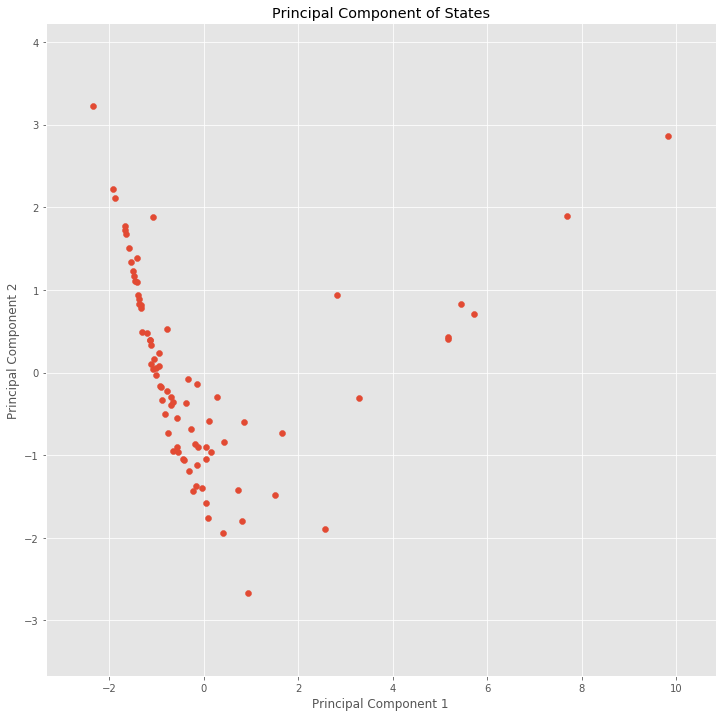

In [22]:
# Scale and define the pricipal components of the Impact Database data
dat=Database[['Magnitude','Intensity (MMI / JMA)','Fatalities','Injuries','displaced','Impact value (D)','buildings damaged','buildings destroyed']].dropna()
sca=scale(dat)
pca_model = PCA()
X_PCA = pca_model.fit_transform(sca)
fig, ax = plt.subplots()
ax.set_xlim(X_PCA[:,0].min()-1,X_PCA[:,0].max()+1)
ax.set_ylim(X_PCA[:,1].min()-1,X_PCA[:,1].max()+1)
plt.scatter(X_PCA[:,0],X_PCA[:,1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Principal Component of States')

next we explore the variance ration. This is to see which of the Principal components we need to use in order t get the best cluster available

In [23]:
var_ratio = pca_model.explained_variance_ratio_
print(var_ratio)

[0.57204901 0.17122451 0.1048144  0.06130814 0.04546535 0.02423484
 0.01563137 0.00527239]


Since our first Principal Component is 0.57 precent variation and our second principal component is 0.17 percent variation, we are okay using PC1 and PC2 as our data set. 

#### Clustering Earthquake Data and USGS Data
Next, we compared our earthquake data set to the USGS one that we found scraped from. This is mainly to see how different the data sets are and how this would affet the clustering.

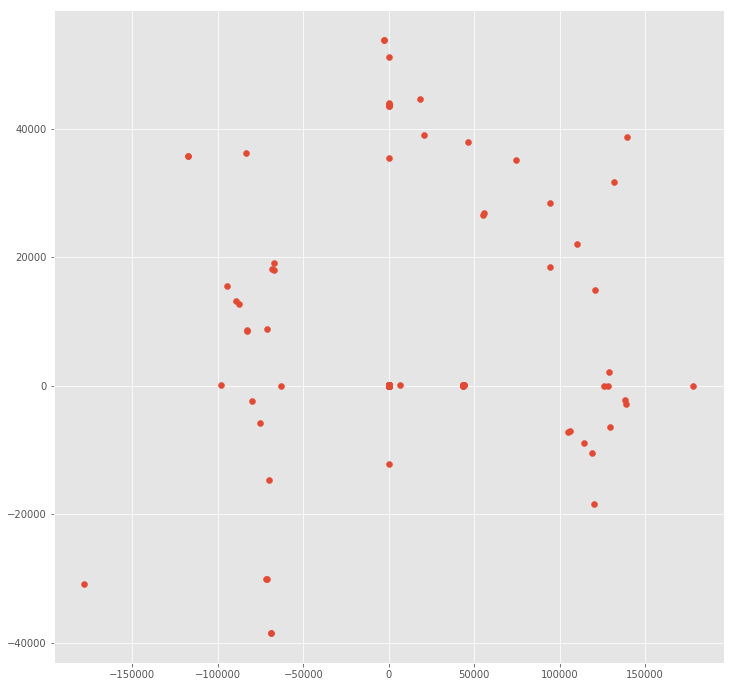

In [24]:
#Scatter from excel sheets
from matplotlib.colors import ListedColormap
cmap = ListedColormap(["#984ea3","#a65628","#ffff33","#4daf4a","#ff7f00", "#e41a1c", "#377eb8"])
plt.scatter(Database['Long'],Database['Lat'])

The USGS data set had a wider variation across the globe. This included more countries and more defined regions that could be explored. Using A variety of clustering, we come to the conclusion that K-means was the best and that we should try clustering by geographic regions first.

C:\Users\paulm\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


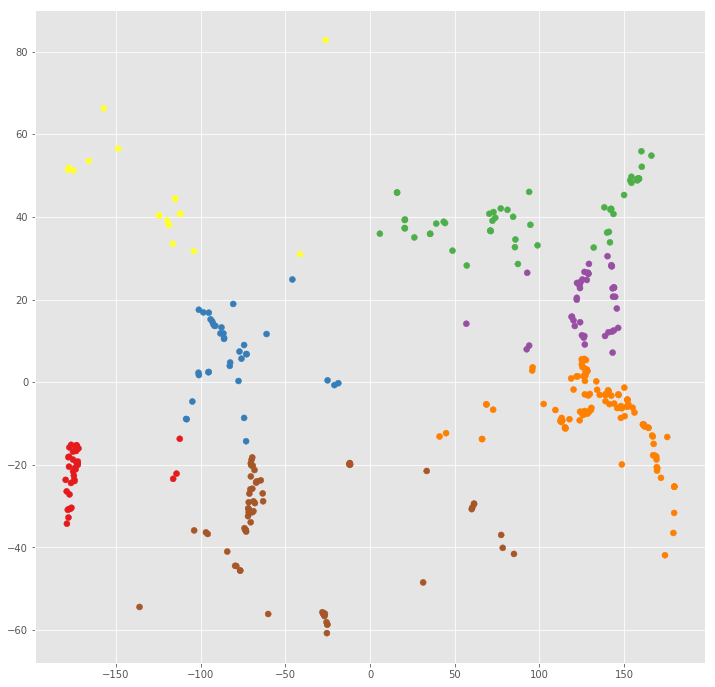

In [25]:
#Kmeans from USGS data. We will use k-means for all other data
quac=Current[['latitude','longitude']]
scal=scale(quac)
y_pred = KMeans(n_clusters=7,n_init=50).fit_predict(scal)
quac['grouping']=y_pred
Current['grouping']=y_pred
Help=Current[['grouping','Country']]
T=Help.groupby('Country').mean().reset_index()
Info=Information.merge(T,how='left',left_on='Country', right_on='Country')
Info.groupby('grouping').count()
plt.scatter(quac['longitude'],quac['latitude'],c=y_pred,cmap=cmap)

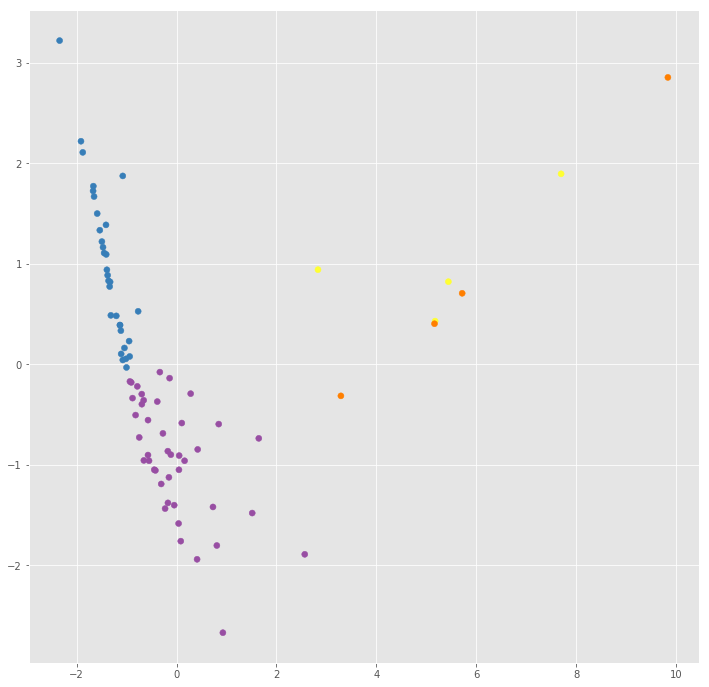

In [26]:
#K-Means is the best (add how)
y_pred = KMeans(n_clusters=4).fit_predict(sca)
dat['grouping']=y_pred
plt.scatter(X_PCA[:,0],X_PCA[:,1],c=y_pred,cmap=cmap)

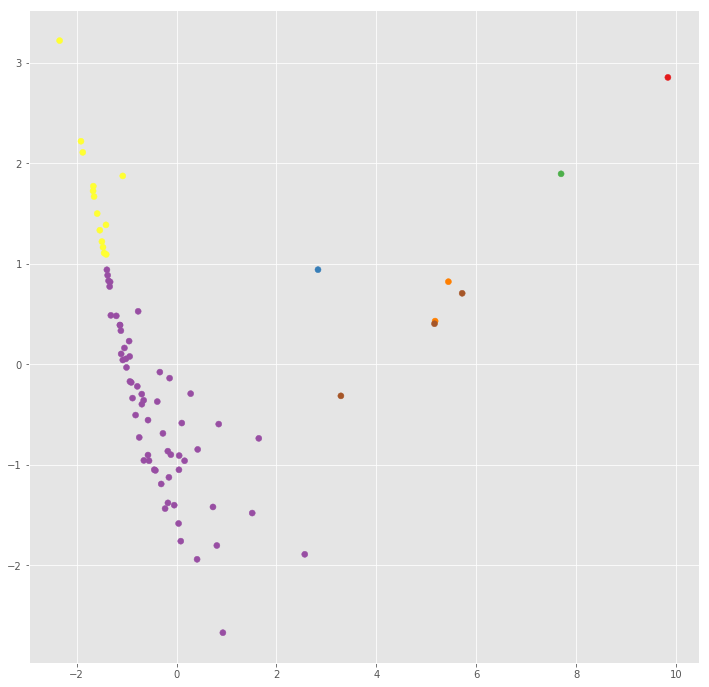

In [27]:
agg_cluster_model = AgglomerativeClustering(linkage='complete', affinity='euclidean', n_clusters=7)
y_pred1 = agg_cluster_model.fit_predict(sca)
dat['grouping1']=y_pred1
plt.scatter(X_PCA[:,0],X_PCA[:,1],c=y_pred1,cmap=cmap)

Clustering by geographic location was actually not as great as was hoped. This is mainly due to issues with seperating countries and regions from the USGS data. The clustering by geographic location could also not be combined with our earthquake data set and resulted in a disconnect between the two.
  
#### Socioeconomic Clustering
Next, we will be moving clustering around the socioeconomic data (GDP, Population, and GDP Per Capita).

C:\Users\paulm\Anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:173: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


Text(0.5, 1.0, 'Principal Component of Earthquake Socioeconomic Data')

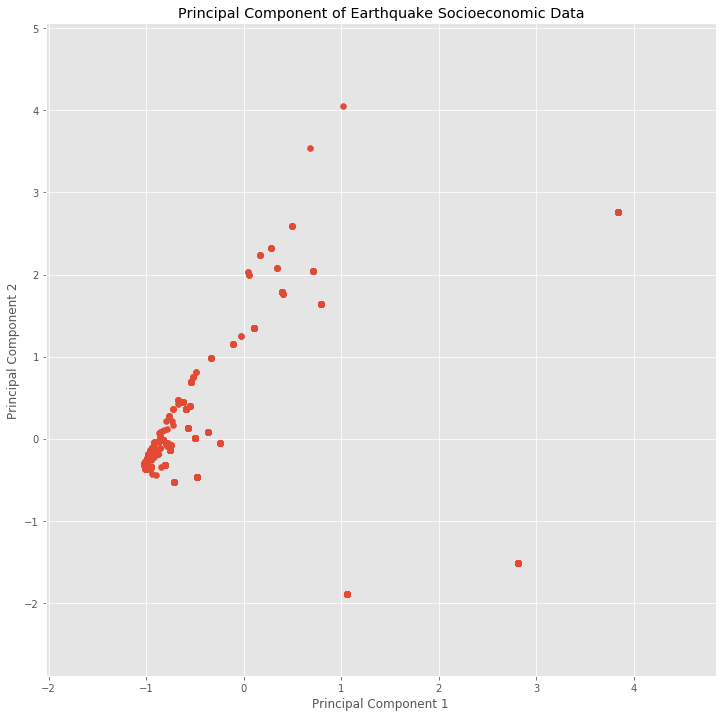

In [28]:
# Broad scaled clustering based on socioeconomic data
earthquake_socio = earthquake_data[["GDP", "Population", "GDPPerCapita"]].copy()
scaled_eq_data = scale(earthquake_socio)
EQ_PCA = pca_model.fit_transform(scaled_eq_data)

fig, ax = plt.subplots()
ax.set_xlim(EQ_PCA[:,0].min()-1,EQ_PCA[:,0].max()+1)
ax.set_ylim(EQ_PCA[:,1].min()-1,EQ_PCA[:,1].max()+1)
plt.scatter(EQ_PCA[:,0],EQ_PCA[:,1])
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Principal Component of Earthquake Socioeconomic Data')

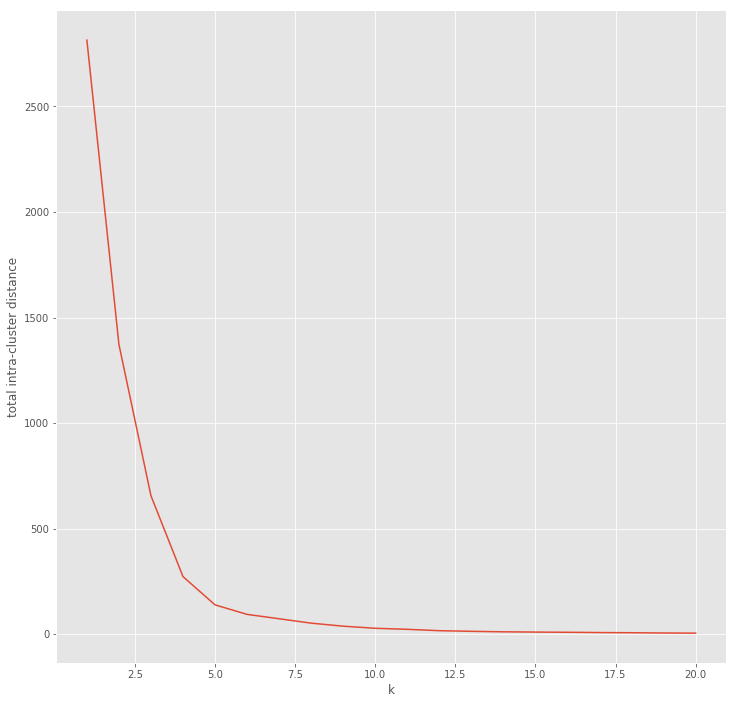

In [29]:
ks = range(1, 21)
scores = []

for k in ks:
    k_model = KMeans (n_clusters = k)
    k_model.fit_predict(scaled_eq_data)
    scores.append(-k_model.score(scaled_eq_data))
    
plt.plot(ks, scores)
plt.xlabel('k')
plt.ylabel('total intra-cluster distance')
plt.show()

A k value of 6 was chosen because it minimizes the intra-cluster distance without overly clustering the data.

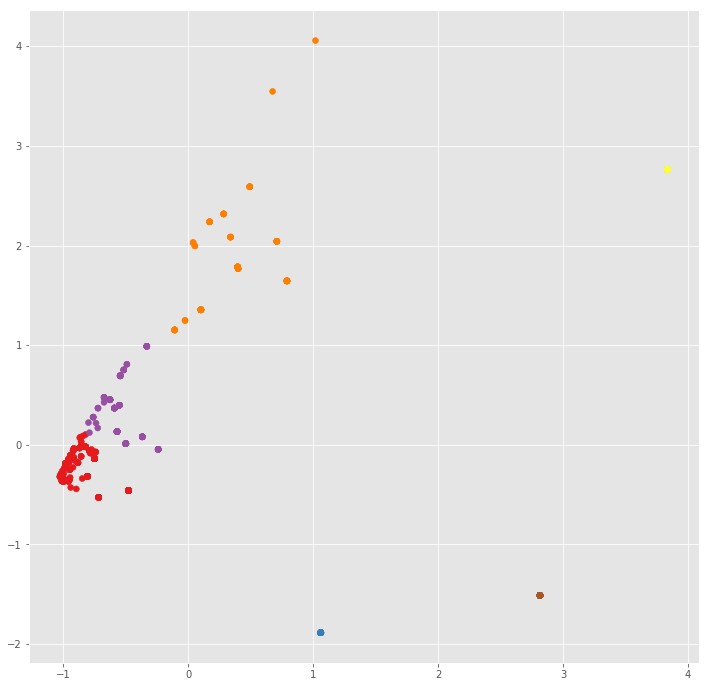

In [30]:
socio_cluster = KMeans(n_clusters = 6).fit_predict(scaled_eq_data)
plt.scatter(EQ_PCA[:,0],EQ_PCA[:,1],c=socio_cluster,cmap=cmap)

In [31]:
earthquake_data_cluster = earthquake_data
earthquake_data_cluster.insert(loc = 18, column = 'Socio Cluster', value = socio_cluster)

In [32]:
earthquake_cluster_0 = earthquake_data_cluster[earthquake_data_cluster['Socio Cluster'] == 0]
earthquake_cluster_1 = earthquake_data_cluster[earthquake_data_cluster['Socio Cluster'] == 1]
earthquake_cluster_2 = earthquake_data_cluster[earthquake_data_cluster['Socio Cluster'] == 2]
earthquake_cluster_3 = earthquake_data_cluster[earthquake_data_cluster['Socio Cluster'] == 3]
earthquake_cluster_4 = earthquake_data_cluster[earthquake_data_cluster['Socio Cluster'] == 4]
earthquake_cluster_5 = earthquake_data_cluster[earthquake_data_cluster['Socio Cluster'] == 5]

### Stage 3: Regressions on Clustered Data

Next we are going to run regressions on the clusters built from the socioeconomic data. The types of regressions will be identical to the ones we created when we regressed the entire data set. 

In [33]:
# Regressions on cluster 0
mag_regress_c0 = regress('Magnitude', earthquake_cluster_0)
maggdp_regress_c0 = regress('Magnitude + GDP', earthquake_cluster_0)
magpop_regress_c0 = regress('Magnitude + Population', earthquake_cluster_0)
maggdppc_regress_c0 = regress('Magnitude + GDPPerCapita', earthquake_cluster_0)
magall_regress_c0 = regress('Magnitude + GDP + Population + GDPPerCapita', earthquake_cluster_0)

In [34]:
# Regressions on cluster 1
mag_regress_c1 = regress('Magnitude', earthquake_cluster_1)
maggdp_regress_c1 = regress('Magnitude + GDP', earthquake_cluster_1)
magpop_regress_c1 = regress('Magnitude + Population', earthquake_cluster_1)
maggdppc_regress_c1 = regress('Magnitude + GDPPerCapita', earthquake_cluster_1)
magall_regress_c1 = regress('Magnitude + GDP + Population + GDPPerCapita', earthquake_cluster_1)

In [35]:
# Regressions on cluster 2
mag_regress_c2 = regress('Magnitude', earthquake_cluster_2)
maggdp_regress_c2 = regress('Magnitude + GDP', earthquake_cluster_2)
magpop_regress_c2 = regress('Magnitude + Population', earthquake_cluster_2)
maggdppc_regress_c2 = regress('Magnitude + GDPPerCapita', earthquake_cluster_2)
magall_regress_c2 = regress('Magnitude + GDP + Population + GDPPerCapita', earthquake_cluster_2)

In [36]:
# Regressions on cluster 3
mag_regress_c3 = regress('Magnitude', earthquake_cluster_3)
maggdp_regress_c3 = regress('Magnitude + GDP', earthquake_cluster_3)
magpop_regress_c3 = regress('Magnitude + Population', earthquake_cluster_3)
maggdppc_regress_c3 = regress('Magnitude + GDPPerCapita', earthquake_cluster_3)
magall_regress_c3 = regress('Magnitude + GDP + Population + GDPPerCapita', earthquake_cluster_3)

In [37]:
# Regressions on cluster 4
mag_regress_c4 = regress('Magnitude', earthquake_cluster_4)
maggdp_regress_c4 = regress('Magnitude + GDP', earthquake_cluster_4)
magpop_regress_c4 = regress('Magnitude + Population', earthquake_cluster_4)
maggdppc_regress_c4 = regress('Magnitude + GDPPerCapita', earthquake_cluster_4)
magall_regress_c4 = regress('Magnitude + GDP + Population + GDPPerCapita', earthquake_cluster_4)

In [38]:
# Regressions on cluster 5
mag_regress_c5 = regress('Magnitude', earthquake_cluster_5)
maggdp_regress_c5 = regress('Magnitude + GDP', earthquake_cluster_5)
magpop_regress_c5 = regress('Magnitude + Population', earthquake_cluster_5)
maggdppc_regress_c5 = regress('Magnitude + GDPPerCapita', earthquake_cluster_5)
magall_regress_c5 = regress('Magnitude + GDP + Population + GDPPerCapita', earthquake_cluster_5)

In [39]:
print("Regressions for All Clusters Based on Magnitude")
regression_df_mag = pd.DataFrame(data = {"Cluster 0": mag_regress_c0, "Cluster 1": mag_regress_c1, "Cluster 2": mag_regress_c2, "Cluster 3": mag_regress_c3, "Cluster 4": mag_regress_c4, "Cluster 5": mag_regress_c5}, index = impact_factors)
regression_df_mag

Regressions for All Clusters Based on Magnitude


,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
Intensity,0.640882,0.835859,0.340572,0.367422,0.251432,1.000000
Fatalities,0.089336,0.110445,0.043808,0.032128,0.027682,0.042324
Injuries,0.080756,0.128585,0.144827,0.042731,0.062145,0.062661
Displaced,0.106470,0.076607,0.046571,0.015822,0.067533,0.014101
Impact Values,0.222980,0.315493,0.302029,0.055357,0.220701,0.050931
Damaged Buildings,0.110025,0.119423,0.227387,0.015473,0.097400,0.034078
Destroyed Buildings,0.117030,0.049128,0.164315,0.039062,0.092306,0.060701


In [40]:
print("Regressions for All Clusters Based on Magnitude and GDP")
regression_df_maggdp = pd.DataFrame(data = {"Cluster 0": maggdp_regress_c0, "Cluster 1": maggdp_regress_c1, "Cluster 2": maggdp_regress_c2, "Cluster 3": maggdp_regress_c3, "Cluster 4": maggdp_regress_c4, "Cluster 5": maggdp_regress_c5}, index = impact_factors)
regression_df_maggdp

Regressions for All Clusters Based on Magnitude and GDP


,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
Intensity,0.653131,0.835859,0.340571,0.391684,0.257011,1.000000
Fatalities,0.110630,0.110444,0.043808,0.059791,0.035651,0.042324
Injuries,0.098925,0.128585,0.144827,0.089326,0.070437,0.062661
Displaced,0.131195,0.076607,0.046571,0.015824,0.073091,0.014101
Impact Values,0.239210,0.315492,0.302029,0.062847,0.225729,0.050931
Damaged Buildings,0.135485,0.119423,0.227387,0.048834,0.100721,0.034078
Destroyed Buildings,0.143705,0.049128,0.164315,0.065507,0.101741,0.060701


In [41]:
print("Regressions for All Clusters Based on Magnitude and Population")
regression_df_magpop = pd.DataFrame(data = {"Cluster 0": magpop_regress_c0, "Cluster 1": magpop_regress_c1, "Cluster 2": magpop_regress_c2, "Cluster 3": magpop_regress_c3, "Cluster 4": magpop_regress_c4, "Cluster 5": magpop_regress_c5}, index = impact_factors)
regression_df_magpop

Regressions for All Clusters Based on Magnitude and Population


,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
Intensity,0.660060,0.835859,0.340572,0.386063,0.260442,1.000000
Fatalities,0.115299,0.110445,0.043808,0.060285,0.035051,0.042324
Injuries,0.102895,0.128585,0.144827,0.092632,0.068307,0.062661
Displaced,0.136570,0.076607,0.046571,0.017881,0.071594,0.014101
Impact Values,0.240549,0.315493,0.302029,0.071133,0.225644,0.050931
Damaged Buildings,0.141054,0.119423,0.227387,0.050680,0.100218,0.034078
Destroyed Buildings,0.149451,0.049128,0.164315,0.066561,0.101466,0.060701


In [42]:
print("Regressions for All Clusters Based on Magnitude and GDP Per Capita")
regression_df_maggdppc = pd.DataFrame(data = {"Cluster 0": maggdppc_regress_c0, "Cluster 1": maggdppc_regress_c1, "Cluster 2": maggdppc_regress_c2, "Cluster 3": maggdppc_regress_c3, "Cluster 4": maggdppc_regress_c4, "Cluster 5": maggdppc_regress_c5}, index = impact_factors)
regression_df_maggdppc

Regressions for All Clusters Based on Magnitude and GDP Per Capita


,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
Intensity,0.687015,0.835859,0.340572,0.367780,0.285523,1.000000
Fatalities,0.105090,0.110445,0.043808,0.033019,0.027683,0.042324
Injuries,0.094314,0.128585,0.144827,0.046104,0.062839,0.062661
Displaced,0.125316,0.076607,0.046571,0.055421,0.067813,0.014101
Impact Values,0.236705,0.315493,0.302029,0.070684,0.221588,0.050931
Damaged Buildings,0.129216,0.119423,0.227387,0.016371,0.097408,0.034078
Destroyed Buildings,0.137941,0.049128,0.164315,0.041473,0.092381,0.060701


In [43]:
print("Regressions for All Clusters Based on Magnitude, GDP, Population, and GDP Per Capita")
regression_df_magall = pd.DataFrame(data = {"Cluster 0": magall_regress_c0, "Cluster 1": magall_regress_c1, "Cluster 2": magall_regress_c2, "Cluster 3": magall_regress_c3, "Cluster 4": magall_regress_c4, "Cluster 5": magall_regress_c5}, index = impact_factors)
regression_df_magall

Regressions for All Clusters Based on Magnitude, GDP, Population, and GDP Per Capita


,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
Intensity,0.692776,0.835852,0.340569,0.401441,0.291761,1.000000
Fatalities,0.122485,0.110445,0.043808,0.062776,0.035686,0.042324
Injuries,0.108907,0.128585,0.144827,0.097261,0.070908,0.062661
Displaced,0.144440,0.076607,0.046571,0.062728,0.073451,0.014101
Impact Values,0.241838,0.315493,0.302029,0.108697,0.227522,0.050931
Damaged Buildings,0.149405,0.119423,0.227387,0.057814,0.100761,0.034078
Destroyed Buildings,0.157479,0.049128,0.164315,0.067034,0.101989,0.060701


Before interpretation, it is important to note that the perfect correlation on the Cluster 5: Intensity for all regressions is caused because the data only has 2 intensity values in it. So no matter what, a linear regression will be perfectly correlated.  
  
To determine which regression was ideal for each cluster, the sum of all $R^{2}$ values was taken. The method with the best overall correlation will have the value of $\sum R^2$ closest to 7 (or the number of regressed impact factors). This works because as the $R^2$ value for each regression approaches 1, the regression describes more variation in the data. 

In [44]:
# sum r_squareds for all clusters and regressions to determine what the best regression is.
regressions = ["Magnitude", "Magnitude and GDP", "Magnitude and Population", "Magnitude and GDP Per Capita", "Magnitude and All"]
c0 = []
c0.append(np.sum(mag_regress_c0))
c0.append(np.sum(maggdp_regress_c0))
c0.append(np.sum(magpop_regress_c0))
c0.append(np.sum(maggdppc_regress_c0))
c0.append(np.sum(magall_regress_c0))

c1 = []
c1.append(np.sum(mag_regress_c1))
c1.append(np.sum(maggdp_regress_c1))
c1.append(np.sum(magpop_regress_c1))
c1.append(np.sum(maggdppc_regress_c1))
c1.append(np.sum(magall_regress_c1))

c2 = []
c2.append(np.sum(mag_regress_c2))
c2.append(np.sum(maggdp_regress_c2))
c2.append(np.sum(magpop_regress_c2))
c2.append(np.sum(maggdppc_regress_c2))
c2.append(np.sum(magall_regress_c2))

c3 = []
c3.append(np.sum(mag_regress_c3))
c3.append(np.sum(maggdp_regress_c3))
c3.append(np.sum(magpop_regress_c3))
c3.append(np.sum(maggdppc_regress_c3))
c3.append(np.sum(magall_regress_c3))

c4 = []
c4.append(np.sum(mag_regress_c4))
c4.append(np.sum(maggdp_regress_c4))
c4.append(np.sum(magpop_regress_c4))
c4.append(np.sum(maggdppc_regress_c4))
c4.append(np.sum(magall_regress_c4))

c5 = []
c5.append(np.sum(mag_regress_c5))
c5.append(np.sum(maggdp_regress_c5))
c5.append(np.sum(magpop_regress_c5))
c5.append(np.sum(maggdppc_regress_c5))
c5.append(np.sum(magall_regress_c5))

regression_df_sums = pd.DataFrame(data = {"Cluster 0": c0, "Cluster 1": c1, "Cluster 2": c2, "Cluster 3": c3, "Cluster 4": c4, "Cluster 5": c5}, index = regressions)
regression_df_sums

,Cluster 0,Cluster 1,Cluster 2,Cluster 3,Cluster 4,Cluster 5
Magnitude,1.367480,1.635541,1.269509,0.567995,0.819199,1.264797
Magnitude and GDP,1.512280,1.635538,1.269508,0.733812,0.864382,1.264797
Magnitude and Population,1.545878,1.635541,1.269509,0.745234,0.862724,1.264797
Magnitude and GDP Per Capita,1.515596,1.635541,1.269509,0.630852,0.855236,1.264797
Magnitude and All,1.617330,1.635534,1.269505,0.857750,0.902079,1.264797


Based on these results, the final regression for all clusters will be based on magnitude and population. 
  
None of the regressions are particularly good, nor accurate. 

In [45]:
def print_param (vect, params):
    # vect: a list of parameters from regression
    # params: list of string parameters from second half of regression formula (in the order that they are included)
    # this means that that is dep = 'Magnitude + GDP' then params = [Magnitude, GDP]
    # len(vect) -1 = len(params)
    statement = ""
    for i in range(len(vect)):
        if i == 0:
            statement = statement + "{:0.4e} + ".format(vect[i])
        elif i < len(params):
            statement = statement + "{:0.4e}*".format(vect[i]) + params[i-1] + " + "
        else:
            statement = statement + "{:0.4e}*".format(vect[i]) + params[i-1]
    print(statement)           
    return 

def regress_param(dep, dat, params):
    #dep: a string variable that has the second half of the formula for the regression (after the ~)
    #dat: data to regression from
    
    intensity = sm.ols(formula = 'Intensity ~ ' + dep, data = dat).fit()
    print("Intensity = ", end = "")
    print_param(intensity.params, params)
                  
    fatalities = sm.ols(formula = 'Fatalities ~ ' + dep, data = dat).fit()
    print("Fatalities = ", end = "")
    print_param(fatalities.params, params)
    
    injuries = sm.ols(formula = 'Injuries ~ ' + dep, data = dat).fit()
    print("Injuries = ", end = "")
    print_param(injuries.params, params)
                  
    displaced = sm.ols(formula = 'displaced ~ ' + dep, data = dat).fit()
    print("Displaced = ", end = "")
    print_param(displaced.params, params)
    
    impact = sm.ols(formula = 'Impact ~ ' + dep, data = dat).fit()
    print("Impact = ", end = "")
    print_param(impact.params, params)
    
    damaged = sm.ols(formula = 'Damaged ~ ' + dep, data = dat).fit()
    print("Damaged = ", end = "")
    print_param(damaged.params, params)
    
    destroyed = sm.ols(formula = 'Destroyed ~ ' + dep, data = dat).fit()
    print("Destroyed = ", end = "")
    print_param(destroyed.params, params)
    
    print ('')
    return

In [46]:
# print regressions for all clusters
params = ['Magnitude', 'Population']

print('Cluster 0:')
regress_param('Magnitude + Population', earthquake_cluster_0, params)

print('Cluster 1:')
regress_param('Magnitude + Population', earthquake_cluster_1, params)

print('Cluster 2: ')
regress_param('Magnitude + Population', earthquake_cluster_2, params)

print('Cluster 3: ')
regress_param('Magnitude + Population', earthquake_cluster_3, params)

print('Cluster 4: ')
regress_param('Magnitude + Population', earthquake_cluster_4, params)

print('Cluster 5: ')
regress_param('Magnitude + Population', earthquake_cluster_5, params)

Cluster 0:
Intensity = 1.8243e+00 + 8.4035e-01*Magnitude + -3.4507e-09*Population
Fatalities = -6.5246e+01 + 1.2792e+01*Magnitude + 1.2493e-07*Population
Injuries = -1.0706e+03 + 2.1166e+02*Magnitude + 2.0136e-06*Population
Displaced = -9.6151e+04 + 1.8724e+04*Magnitude + 1.8061e-04*Population
Impact = -1.2739e+00 + 3.1348e-01*Magnitude + 1.6741e-09*Population
Damaged = -3.3731e+04 + 6.5812e+03*Magnitude + 6.3410e-05*Population
Destroyed = -9.6942e+03 + 1.8947e+03*Magnitude + 1.8109e-05*Population

Cluster 1:
Intensity = 2.5429e-17 + 1.4539e+00*Magnitude + -6.8126e-10*Population
Fatalities = -3.6132e-18 + 1.3975e+00*Magnitude + -4.2721e-09*Population
Injuries = -7.6912e-17 + 2.9805e+01*Magnitude + -9.0902e-08*Population
Displaced = -9.6527e-15 + 3.8720e+03*Magnitude + -1.1327e-05*Population
Impact = -1.5066e-18 + 6.8453e-01*Magnitude + -1.7185e-09*Population
Damaged = -1.1708e-14 + 4.7329e+03*Magnitude + -1.3717e-05*Population
Destroyed = -1.5587e-15 + 6.3992e+02*Magnitude + -1.8201e-0

## Results and Validation [Check Off: Katie, Paul]

In [47]:
# Information about the Magna, UT earthquake on Wednesday, March 18th, 2020. Taken from the Earthquake Impact Database 
#on April 12th, 2020
utah_magnitude = 5.7
utah_intensity = 7
utah_fatalities = 0
utah_injuries = 0
utah_displaced = 150
utah_impact = 0.742
utah_buildings_damaged = 192
utah_buildings_destroyed = 0

utah_values = [7, 0, 0, 150, 0.742, 192, 0]

# Information from Socioeconomic data table about the US
us_gdp = gdp.iloc[0 , 2]
us_pop = gdp.iloc[0 , 5]
us_gdppc = gdp.iloc[0 , 6]

In [48]:
utah_calc = []
utah_calc.append(2.5655e-17 + 6.6904e-1*utah_magnitude + 7.6929e-09*us_pop)
utah_calc.append(-1.5734e-17 + 1.237e-1*utah_magnitude - 1.3437e-09*us_pop)
utah_calc.append(-8.5890e-16 + 6.0808*utah_magnitude - 7.7601e-8*us_pop)
utah_calc.append(-1.9876e-14 + 1.4359e2*utah_magnitude - 1.7005e-06*us_pop)
utah_calc.append(-3.3625e-17 + 2.4074e-1*utah_magnitude - 2.9489e-09*us_pop)
utah_calc.append(-7.0803e-14 + 5.0147e2*utah_magnitude - 6.3904e-06*us_pop)
utah_calc.append(-3.2047e-15 + 2.285e1*utah_magnitude - 2.8411e-07*us_pop)

print("Calculated Impact of Utah Earthquake on 3/18/2020:")
for i in range(len(utah_calc)):
    print(impact_factors[i] + ": {:0.2f}".format(utah_calc[i]))

Calculated Impact of Utah Earthquake on 3/18/2020:
Intensity: 6.31
Fatalities: 0.27
Injuries: 9.43
Displaced: 265.66
Impact Values: 0.41
Damaged Buildings: 780.96
Destroyed Buildings: 37.89


In [49]:
#print percent errors for all impact factors
print("Absolute Error of Impact of Utah Earthquake on 3/18/2020:")
for i in range(len(utah_calc)):
    perror = np.abs(utah_values[i]-utah_calc[i])
    print(impact_factors[i] + ": {:0.2f}".format((perror)))

Absolute Error of Impact of Utah Earthquake on 3/18/2020:
Intensity: 0.69
Fatalities: 0.27
Injuries: 9.43
Displaced: 115.66
Impact Values: 0.33
Damaged Buildings: 588.96
Destroyed Buildings: 37.89


Next we created an informational table that describes the probability of each magnitude of earthquake based on the country entered in. This was used to see how often certain magnitudes happen. For some countries certain magnitudes may happen more often than others. Also, It would be interesting to know which region has the most earthquakes in each country.

In [50]:
def probability(c):
    its=[3,4,5,6,7,8,9,10]
    m=[]
    for i in range(len(its)-1):
        stamp=earthquake_data[(its[i]<= earthquake_data['Magnitude'])&(earthquake_data['Magnitude']<its[i+1])]
        try:
            t=round(len(stamp.groupby(['Country']).get_group(c))/len(earthquake_data.groupby(['Country']).get_group(c))*100,1)
        except:
            t='nana'
        m.append(t)
    return(m)

def biggets(c):
    stamp=earthquake_data.groupby(['Country']).get_group(c)
    smoke=stamp['Magnitude'].idxmax()
    big=earthquake_data.iloc[[smoke]]
    r=big['Region'].mode()[0]
    m=big['Magnitude'].mode()[0]
    return(r,m)


def frequent(c):
    stamp=earthquake_data.groupby(['Country']).get_group(c)
    smoke=stamp['Region'].value_counts().max()
    con=stamp['Region'].mode()[0]
    return(con,smoke)

In [65]:
# In the c field, place the country you would like the statistics on. We have added 'Philippines' as an example.
c='Philippines'
cool=list(earthquake_data['Country'])
if c in cool:
    prob=probability(c)
    b=biggets(c)
    f=frequent(c)
    team=earthquake_data.groupby(['Country']).get_group(c)
    L=team['Landarea'].mode()[0]
    C=team['Continents'].mode()[0]
    P=team['Population'].mode()[0]
    G=team['GDP'].mode()[0]
    Gp=team['GDPPerCapita'].mode()[0]
else:
    print('pick anouther country')

In [66]:
CMD="""
######################################
     EARTHQUAKE INFO (2017-2020)
######################################

\033[1m------%s---------\033[0m\n
\033[1m Land Area(miles^2): \033[0m %s
\033[1m Continent: \033[0m %s
\033[1m Population: \033[0m %s
\033[1m GDP($): \033[0m %s
\033[1m GDP per Capita: \033[0m %s\n
\033[1m---------Data----------\033[0m\n
\033[1m Biggest: \033[0m %s
\033[1m Region: \033[0m %s
\033[1m Most Eartquakes: \033[0m %s
\033[1m Number: \033[0m %s\n
\033[1m---------Probability of Magnitude----------\033[0m
""" %(c,str(int(L)),C,str(int(P)),str(int(G)),str(int(Gp)),str(b[1]),str(b[0]),str(f[0]),str(f[1]))

print(CMD)
for i in range(len(prob)):
    print('\033[1m Magnitude %dM: \033[0m %s '%(i+3,str(prob[i])))


######################################
     EARTHQUAKE INFO (2017-2020)
######################################

------Philippines---------

 Land Area(miles^2):  115831
 Continent:  ASIA
 Population:  105172925
 GDP($):  313595208737
 GDP per Capita:  2982

---------Data----------

 Biggest:  7.3
 Region:  Sulu (OS)
 Most Eartquakes:  North Cotabato
 Number:  4

---------Probability of Magnitude----------

 Magnitude 3M:  3.0 
 Magnitude 4M:  15.2 
 Magnitude 5M:  39.4 
 Magnitude 6M:  39.4 
 Magnitude 7M:  3.0 
 Magnitude 8M:  nana 
 Magnitude 9M:  nana 


## Conclusions [Check Off: Katie, Paul]

## References

[A] - https://earthquake.usgs.gov/learn/glossary/?term=intensity  
[B] - https://earthquake-report.com/2018/02/10/earthquake-impact-database-2018/  
[C] - https://en.wikipedia.org/wiki/Taiwan  
[D] - https://en.wikipedia.org/wiki/Venezuela  
[E] - https://en.wikipedia.org/wiki/Myanmar  
[F] - https://en.wikipedia.org/wiki/Cayman_Islands  
[G] - https://www.worldometers.info/gdp/gdp-by-country/
[H] - https://www.worldatlas.com/cntycont.htm
[I] - https://www.nationmaster.com/country-info/stats/Geography/Land-area/Square-miles